copy from https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb

In [1]:
import tensorflow as tf
import numpy as np
from time import time

import keras
from keras import models
from keras import layers
from keras.layers import Input, Dense

import matplotlib.pyplot as plt

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In this section, we implement PINNs as a class which can be used for further testing. Here, we derive the class `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`.

In [3]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub, 
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        
        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

Next, we derive a class `PINNSolver` which can be used as a base class.
It possesses two methods to solve the PDE:
  1. the method `solve_with_TFoptimizer` uses a `TensorFlow` optimizer object as input, e.g., the `AdamOptimizer` above;
  2. the method `solve_with_LBFGS` resembles the LBFGS method proposed in the original paper using an LBFGS method provided by [`SciPy`](https://www.scipy.org/).

In [4]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)
    
    def loss_fn(self, X, u):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - viscosity * u_xx
    
    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Solution of a time-dependent Eikonal equation

As a second example we consider the one-dimensional Eikonal equation backward in time on the domain $\mathcal{D}=[-1,1]$

$$
\begin{align}
   -\partial_t u(t,x) + |\nabla u|(t,x) &= 1, 
   		\quad & &(t,x) \in [0,T) \times [-1,1],\\
   u(T,x) &= 0, \quad & &x \in [-1,1],\\
   u(t,-1) = u(t, 1) &= 0, \quad & & t \in [0,T).
\end{align}
$$


Note that the partial differential equation can be equally written as a Hamilton-Jacobi-Bellman equation, viz

$$
    -\partial_t u(t,x) + \sup_{|c| \le 1} \{c \, \nabla u(t,x)\} = 1 \quad (t,x) \in [0,T) \times [-1,1],
$$

which characterizes the solution of an optimal control problem seeking to minimize the distance from a point $(t,x)$ to the boundary $[0,T] \times \partial \mathcal{D} \cup \{T\} \times \mathcal{D}$.
As is easily verified, the solution is given by $u(t,x) = \min\{ 1 - t, 1 - |x| \}$.
The fact that the Eikonal equation runs backward in time is in accordance with its interpretation as the optimality condition of a control problem.
Note that this is equation can be transformed into a forward evolution problem by the change of variables $\hat t = T - t$.

#### Problem specific definitions

In [5]:
N_0 = 50
N_b = 50
N_r = 10000

# Specify boundaries
lb = tf.constant([0., -1.], dtype=DTYPE)
ub = tf.constant([1., 1.], dtype=DTYPE)

def Eikonal_u_0(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def Eikonal_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

#### Generate data
This code snippet is almost identical to the code from above.
We choose $N_b = 50$ and $N_0 = 50$ uniformly distributed initial value and boundary points and sample $N_r = 10000$ collocation points uniformly within the domain boundaries.
We derive a new solver with `PINNSolver` as base class.

In [6]:
tf.random.set_seed(0)

# Final time data
t_0 = tf.ones((N_0,1), dtype=DTYPE) * ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)
u_0 = Eikonal_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)
u_b = Eikonal_u_b(t_b, x_b)

# Collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0,X_b]
u_data = [u_0,u_b]

#### Derive Eikonal solver class
Now, we derive a solver for the Eikonal equation from the `PINNSolver` class. Since the Eikonal equation does not depend on second-order derivatives, we implement a new method `get_r` which avoids the computation of second derivatives.

In [7]:
class EikonalPINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return -u_t + tf.abs(u_x) - 1.
    
    def get_r(self):
        """We update get_r since the Eikonal equation is a first-order equation.
        Therefore, it is not necessary to compute second derivatives."""
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
        u_x = tape.gradient(u, self.x)
            
        u_t = tape.gradient(u, self.t)
        
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, None)

#### Setting up the neural network architecture

The neural network model chosen for this particular problem can be simpler.
We decided to use only two hidden layers with 20 neurons in each, resulting in $501$ unknown parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; one intermediate layer: $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).
To account for the lack of smoothness of the solution, we choose a non-differentiable activation function, although the hyperbolic tangent function seems to be able to approximate the kinks in the solution sufficiently well.
Here, we decided to use the \emph{leaky rectified linear unit (leaky ReLU)} activation function 

$$
\begin{align*}
    \sigma(z) = \begin{cases}
        z &\text{ if } z \ge 0,\\
        0.1 \, z &\text{ otherwise},
    \end{cases}
\end{align*}
$$

which displays a non-vanishing gradient when the unit is not active, i.e., when $z < 0$.

In [8]:
# Initialize model
model = PINN_NeuralNet(lb, ub, num_hidden_layers=2,
                       activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                                       kernel_initializer='he_normal')
model.build(input_shape=(None,2))

# Initilize PINN solver
eikonalSolver = EikonalPINNSolver(model, X_r)

Start training (take approximately 40 seconds).

In [9]:
# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time()
eikonalSolver.solve_with_TFoptimizer(optim, X_data, u_data, N=10001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.27493477e+00
It 00050: loss = 1.90033674e-01
It 00100: loss = 4.06803861e-02
It 00150: loss = 1.73266754e-02
It 00200: loss = 4.88130609e-03
It 00250: loss = 2.29455600e-03
It 00300: loss = 1.10106845e-03
It 00350: loss = 6.07089838e-04
It 00400: loss = 2.15701686e-04
It 00450: loss = 7.24760685e-05
It 00500: loss = 9.63530765e-05
It 00550: loss = 7.32919871e-05
It 00600: loss = 1.03010389e-04
It 00650: loss = 1.70840285e-04
It 00700: loss = 9.63718485e-05
It 00750: loss = 1.53937566e-04
It 00800: loss = 2.08864207e-04
It 00850: loss = 1.99058326e-04
It 00900: loss = 2.24585892e-04
It 00950: loss = 8.68727730e-05
It 01000: loss = 2.79828037e-05
It 01050: loss = 3.19274392e-07
It 01100: loss = 2.37708974e-07
It 01150: loss = 1.91501911e-07
It 01200: loss = 1.52966436e-07
It 01250: loss = 1.22591601e-07
It 01300: loss = 1.02366549e-07
It 01350: loss = 8.32961362e-08
It 01400: loss = 6.66342572e-08
It 01450: loss = 5.34050315e-08
It 01500: loss = 4.38598065e-08
It 01550

Plot the results.

<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

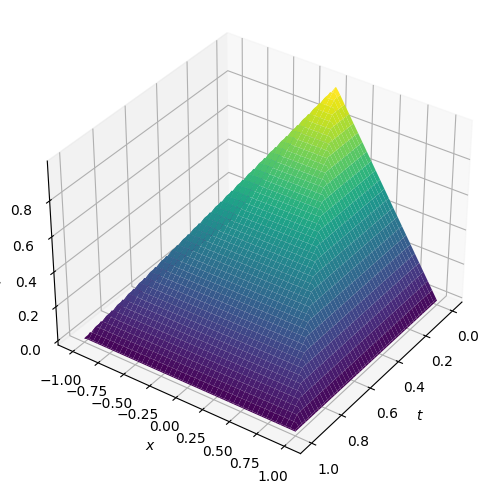

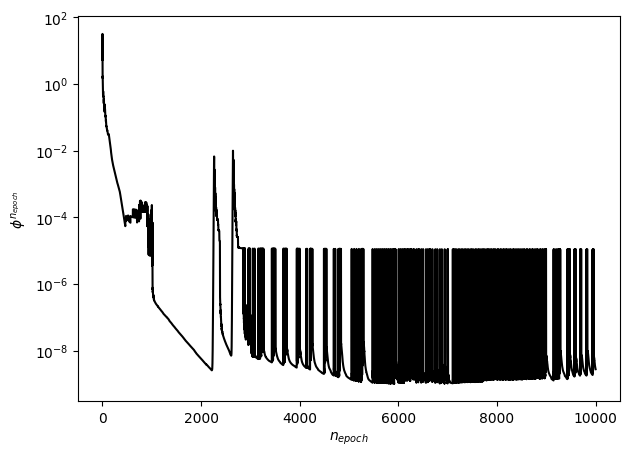

In [10]:
eikonalSolver.plot_solution()
#plt.savefig('Eikonal_Solution.pdf', bbox_inches='tight', dpi=300)
eikonalSolver.plot_loss_history()

# Black Scholes Equation
$
{\frac {\partial V}{\partial t}}+{\frac {1}{2}}\sigma ^{2}S^{2}{\frac {\partial ^{2}V}{\partial S^{2}}}+rS{\frac {\partial V}{\partial S}}-rV=0
$